In [1]:
# imports and config constants (refactored to per-agent modules)
import os, json, pathlib
from datetime import datetime
from typing import Dict, List
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import importlib
from IPython.display import Image

# Load .env 
from dotenv import load_dotenv
load_dotenv()

# Add project root to Python path
project_root = Path.cwd().parent 
sys.path.insert(0, str(project_root))

# Display model environment variables used by agents
print({k: os.getenv(k) for k in [
    "MODEL_NAME",
    "TEACHER_MODEL",
    "GRADING_MODEL",
    "COORDINATOR_MODEL",
    "STUDENT_MODEL",
    "CRITIQUE_EVAL_MODEL",
]})

{'MODEL_NAME': 'gpt-4o', 'TEACHER_MODEL': 'o3', 'GRADING_MODEL': None, 'COORDINATOR_MODEL': 'gpt-4o', 'STUDENT_MODEL': 'gpt-4o', 'CRITIQUE_EVAL_MODEL': 'gpt-4o-mini'}


In [2]:
# imports and config constants (refactored to per-agent modules)
import os, json, pathlib
from datetime import datetime
from typing import Dict, List
from typing_extensions import TypedDict
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import importlib

# Add project root to Python path
project_root = Path.cwd().parent 
sys.path.insert(0, str(project_root))

from src.graphs.adaptive_refinement_graph import create_adaptive_refinement_graph, create_initial_state as adaptive_state
from src.graphs.baseline_graph import create_baseline_graph, create_initial_state as baseline_state
from src.utils.gpqa_sampler import create_gpqa_quiz

THRESHOLD = 0.7
MAX_ITERS = 3
BASE_OUT = pathlib.Path("results")
BASE_OUT.mkdir(parents=True, exist_ok=True)

In [3]:
# Run baseline
baseline_graph = create_baseline_graph()

# Run adaptive
adaptive_graph = create_adaptive_refinement_graph()
# adaptive_results = adaptive.invoke(adaptive_state(gpqa_quiz=QUIZ))

In [4]:
# optional: initialize TruLens OpenAI provider to compute simple relevance
try:
    from trulens.providers.openai import OpenAI as TruOpenAI
    tru_provider = TruOpenAI(model_engine="gpt-4o-mini")
except Exception as e:
    tru_provider = None
    print("TruLens provider init failed:", e)

In [4]:
# TruLens LangGraph recorder (logs interactions)
try:
    from trulens.core.database.connector.default import DefaultDBConnector
    from trulens.core.session import TruSession
    from trulens.apps.langgraph import TruGraph

    connector = DefaultDBConnector(database_url="sqlite:///edu_refine.sqlite")
    tru_session = TruSession(connector=connector)

    # Recorder for adaptive refinement graph
    tru_recorder = TruGraph(adaptive_graph, app_name="Educational Refinement Agent", app_version="mvp-adaptive")

    # Recorder for baseline graph
    tru_baseline_recorder = TruGraph(baseline_graph, app_name="Educational Refinement Agent", app_version="mvp-baseline")
except Exception as e:
    tru_recorder = None
    tru_baseline_recorder = None
    print("TruGraph init failed:", e)

🦑 Initialized with db url sqlite:///edu_refine.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.
✅ experimental Feature.OTEL_TRACING enabled.
🔒 experimental Feature.OTEL_TRACING is enabled and cannot be changed.
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.graph.state.CompiledStateGraph'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.pregel.main.Pregel'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <c

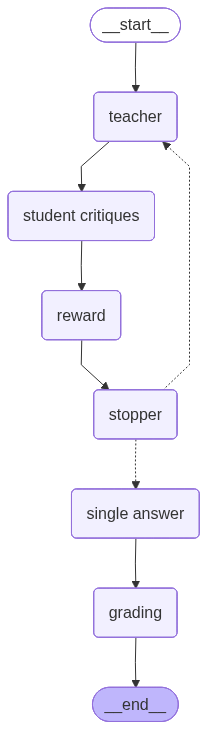

In [5]:
from IPython.display import Image

display(Image(adaptive_graph.get_graph().draw_mermaid_png()))

In [ ]:
initial_state = {
    "gpqa_question": quiz[0],
    "threshold": THRESHOLD,
    "max_iters": MAX_ITERS,
    "history": []
}

if 'tru_recorder' in globals() and tru_recorder is not None:
    with tru_recorder as recording:
        state = adaptive_graph.invoke(initial_state, config={"recursion_limit": 30})
else:
    state = adaptive_graph.invoke(initial_state, config={"recursion_limit": 30})

# Build results dict (single-answer evaluation)
results = {
    "dataset": "GPQA",
    "subset": locals().get("subset", "gpqa_main"),
    "domain": locals().get("domain", "Physics"),
    "gpqa_index": locals().get("idx", None),
    "record_id": state.get("gpqa_question", {}).get("id"),
    "question": state.get("gpqa_question", {}).get("question", ""),
    "iterations": state.get("iteration", 0),
    "final_scores": state.get("reward_scores", {}),
    "final_explanation": state.get("explanation", ""),
    "history": state.get("history", []),
    "gpqa_question": state.get("gpqa_question", {}),
    "single_answer": state.get("single_answer", ""),
    "single_explanation": state.get("single_explanation", ""),
    "quiz_results": state.get("quiz_results", {}),
}

print("Dataset:", results["dataset"], results["subset"], results["domain"]) 
print("Record ID:", results["record_id"]) 
print("Question:", results["question"]) 
print("Iterations:", results["iterations"]) 
print("Final scores:", results["final_scores"]) 
print("\nFinal explanation (truncated to 800 chars):\n")
print(results["final_explanation"][:800])

# Print question block
qobj = results.get("gpqa_question", {})
if qobj:
    print("\nGPQA Question:")
    print(f"- ID: {qobj.get('id','')}")
    print(f"  Stem: {qobj.get('question','').strip()}")
    for opt in qobj.get("options", []):
        print(f"  {opt}")
    print(f"  Correct: {qobj.get('correct','?')}")

# Single answer and explanation
print("\nSingle Answer Evaluation:")
print(f"- Predicted: {results.get('single_answer','?')}")
print(f"- One-sentence explanation: {results.get('single_explanation','')}")

quiz_results = results.get("quiz_results", {})
if quiz_results:
    print("\nQuiz Results:")
    print(f"- Correct: {quiz_results.get('is_correct', False)}")
    sim = quiz_results.get("explanation_similarity", 0.0)
    print(f"- Explanation similarity: {sim*100:.1f}%")

# Persist results to results/ with timestamped filename
_ts = datetime.now().strftime("%Y%m%d_%H%M%S")

def _slugify(s: str, limit: int = 40) -> str:
    s = (s or "").strip()
    slug = "".join(ch if ch.isalnum() else "_" for ch in s)
    return slug[:limit] if limit > 0 else slug

_id_part = results.get("record_id") or _slugify(results["question"]) or "run"
outfile = BASE_OUT / f"run_{_ts}_{_id_part}.json"
record = {
    "timestamp": _ts,
    "dataset": results["dataset"],
    "subset": results["subset"],
    "domain": results["domain"],
    "gpqa_index": results.get("gpqa_index"),
    "record_id": results.get("record_id"),
    "question": results["question"],
    "final_explanation": results["final_explanation"],
    "iterations": results["iterations"],
    "final_scores": results["final_scores"],
    "gpqa_question": results.get("gpqa_question", {}),
    "single_answer": results.get("single_answer", ""),
    "single_explanation": results.get("single_explanation", ""),
    "quiz_results": results.get("quiz_results", {}),
}
outfile.write_text(json.dumps(record, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"\nSaved results to: {outfile}")

Loading GPQA cache from: C:\Users\vedan\Desktop\playing-devils-advocate\data\cache\gpqa_main_Physics_train.json
Loaded 182 Physics questions from gpqa_main


In [14]:
baseline_summary = {
    "total_questions": 0,
    "correct_counts": {},
    "justification_scores": {}
}

adaptive_summary = {
    "total_questions": 0,
    "correct_counts": {},
    "justification_scores": {}
}

baseline_explanations = []
adaptive_explanations = []

for i in range(len(quiz)):
    
    print(f"Asking question {i+1}/{len(quiz)}...")
    gpqa_question = quiz[i]
    
    # Run baseline with recording
    if 'baseline_recorder' in globals() and baseline_recorder is not None:
        with baseline_recorder as recording:
            baseline_results = baseline_graph.invoke(baseline_state(gpqa_question),
                                                    config={"recursion_limit": 30})
    baseline_summary = update_summary(baseline_summary, baseline_results['quiz_results'])
    entry = {'id': baseline_results['gpqa_question']['id'], 
             'explanation': baseline_results['explanation']}
    baseline_explanations.append(entry)
                                     
    # Run adaptive with recording  
    if 'adaptive_recorder' in globals() and adaptive_recorder is not None:
        with adaptive_recorder as recording:
            adaptive_results = adaptive_graph.invoke(adaptive_state(gpqa_question, max_iters = 3),
                                                    config={"recursion_limit": 30})
    adaptive_summary = update_summary(adaptive_summary, adaptive_results['quiz_results'])
    entry = {'id': adaptive_results['gpqa_question']['id'], 
             'explanation': adaptive_results['explanation']}
    adaptive_explanations.append(entry)

Asking question 1/5...
Asking question 2/5...
Asking question 3/5...
Asking question 4/5...
Asking question 5/5...


In [15]:
df_adapt = results_to_df(adaptive_summary)
df_adapt

,persona,correct_counts,justification_scores
0,advanced,0.0,2.6
1,struggling,0.0,2.2
2,skeptical_misconception,0.0,2.2
3,practical,0.0,2.4
4,theoretical,0.0,2.2


In [16]:
df_base = results_to_df(baseline_summary)
df_base

,persona,correct_counts,justification_scores
0,advanced,0.0,2.0
1,struggling,0.0,1.8
2,skeptical_misconception,0.0,1.8
3,practical,0.0,2.0
4,theoretical,0.0,2.2


In [6]:
# launch TruLens dashboard to view agent interactions
from trulens.dashboard import run_dashboard
run_dashboard()  # prints a local URL (e.g., http://localhost:8501); open it in your browser

Starting dashboard ...


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://localhost:51264 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

In [8]:
# Baseline batch run: 20 Physics questions (progress + JSON)
import json
import time
from datetime import datetime
from pathlib import Path
try:
    from tqdm.notebook import tqdm
except Exception:
    from tqdm import tqdm

subset = "gpqa_main"
domain = "Physics"
seed = 100
num_questions = 20
# Per-question delay (seconds) to avoid rate limits
delay_secs = 10

quiz, indices = create_gpqa_quiz(subset=subset, domain=domain, seed=seed, num_questions=num_questions)

try:
    _bg = baseline_graph  # type: ignore[name-defined]
except Exception:
    _bg = create_baseline_graph()

rows = []

# If TruLens baseline recorder is available, wrap the loop so each invoke is traced
if 'tru_baseline_recorder' in globals() and tru_baseline_recorder is not None:
    context_manager = tru_baseline_recorder
else:
    from contextlib import nullcontext
    context_manager = nullcontext()

with context_manager as recording:
    for q in tqdm(quiz, total=len(quiz), desc="Baseline (Physics)"):
        init = baseline_state(gpqa_question=q, threshold=THRESHOLD, max_iters=1)
        state = _bg.invoke(init, config={"recursion_limit": 10})
        gpqa_q = state.get("gpqa_question", {})
        quiz_res = state.get("quiz_results", {}) or {}

        # correct letter and option text
        correct_letter = str(gpqa_q.get("correct", "")).strip().upper()
        correct_text = ""
        opts = [str(x) for x in (gpqa_q.get("options", []) or [])]
        if correct_letter in {"A","B","C","D"}:
            for opt in opts:
                if len(opt) >= 2 and opt[0].upper() == correct_letter:
                    correct_text = opt[2:].strip() if len(opt) > 2 else ""
                    break

        rows.append({
            "id": gpqa_q.get("id"),
            "question": gpqa_q.get("question", ""),
            "correct": correct_letter,
            "correct_text": correct_text,
            "teacher_explanation": state.get("explanation", ""),
            "llm_answer": state.get("single_answer", ""),
            "llm_one_sentence": state.get("single_explanation", ""),
            "similarity": quiz_res.get("explanation_similarity", 0.0),
            "is_correct": bool(quiz_res.get("is_correct", False)),
        })

        # Wait between requests to avoid rate limits
        time.sleep(delay_secs)

_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
outfile = Path("results") / f"baseline_batch_{_ts}.json"
outfile.parent.mkdir(parents=True, exist_ok=True)
outfile.write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"Saved {len(rows)} results to {outfile}")

Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics_train.json
Loaded 187 Physics questions from gpqa_main


Baseline (Physics):   0%|          | 0/20 [00:00<?, ?it/s]

Saved 20 results to results\baseline_batch_20251115_172542.json


In [8]:
# Adaptive batch run: 20 Physics questions (progress + JSON)
import json
import time
from datetime import datetime
from pathlib import Path
try:
    from tqdm.notebook import tqdm
except Exception:
    from tqdm import tqdm

subset = "gpqa_main"
domain = "Physics"
seed = 100
num_questions = 20
# Per-question delay (seconds) to avoid rate limits
delay_secs = 10

quiz, indices = create_gpqa_quiz(subset=subset, domain=domain, seed=seed, num_questions=num_questions)

try:
    _ag = adaptive_graph  # type: ignore[name-defined]
except Exception:
    _ag = create_adaptive_refinement_graph()

rows = []

# If TruLens adaptive recorder is available, wrap the loop so each invoke is traced
if 'tru_recorder' in globals() and tru_recorder is not None:
    context_manager = tru_recorder
else:
    from contextlib import nullcontext
    context_manager = nullcontext()

_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
outfile = Path("results") / f"adaptive_batch_{_ts}.json"
outfile.parent.mkdir(parents=True, exist_ok=True)

with context_manager as recording:
    for q in tqdm(quiz, total=len(quiz), desc="Adaptive (Physics)"):
        init = adaptive_state(gpqa_question=q, threshold=THRESHOLD, max_iters=MAX_ITERS)
        state = _ag.invoke(init, config={"recursion_limit": 30})
        gpqa_q = state.get("gpqa_question", {})
        quiz_res = state.get("quiz_results", {}) or {}

        correct_letter = str(gpqa_q.get("correct", "")).strip().upper()
        correct_text = ""
        opts = [str(x) for x in (gpqa_q.get("options", []) or [])]
        if correct_letter in {"A","B","C","D"}:
            for opt in opts:
                if len(opt) >= 2 and opt[0].upper() == correct_letter:
                    correct_text = opt[2:].strip() if len(opt) > 2 else ""
                    break

        rows.append({
            "id": gpqa_q.get("id"),
            "question": gpqa_q.get("question", ""),
            "correct": correct_letter,
            "correct_text": correct_text,
            "teacher_explanation": state.get("explanation", ""),
            "llm_answer": state.get("single_answer", ""),
            "llm_one_sentence": state.get("single_explanation", ""),
            "similarity": quiz_res.get("explanation_similarity", 0.0),
            "is_correct": bool(quiz_res.get("is_correct", False)),
        })

        outfile.write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")

        time.sleep(delay_secs)

print(f"Saved {len(rows)} results to {outfile}")

Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics_train.json
Loaded 187 Physics questions from gpqa_main


Adaptive (Physics):   0%|          | 0/20 [00:00<?, ?it/s]

Saved 20 results to results\adaptive_batch_20251116_161618.json


In [9]:
from src.config.agent_config import _model_for_role
from src.agents.teacher_agent import teacher_explain
from src.utils.gpqa_sampler import create_gpqa_quiz

subset = "gpqa_main"
domain = "Physics"
seed = 123
print("Effective teacher model:", _model_for_role("teacher"))

try:
    quiz, _ = create_gpqa_quiz(subset=subset, domain=domain, seed=seed, num_questions=1)
    q = quiz[0]["question"]
    print("Question preview:", q[:200].replace("\n"," "), "\n")
except Exception as e:
    print("Failed to load GPQA question:", e)
    q = "What is the speed of light in vacuum?"

try:
    text = teacher_explain(q, mode="adaptive", student_feedback=None, word_cap=180, max_tokens=500)
    print("Teacher explanation length:", len(text))
    print("Teacher explanation preview:", text[:400])
    if not text.strip():
        print("WARNING: teacher_explain returned empty text.")
except Exception as e:
    print("teacher_explain raised:", repr(e))

try:
    text2 = teacher_explain(q, mode="baseline", student_feedback=None, word_cap=180, max_tokens=500)
    print("Baseline explanation length:", len(text2))
    print("Baseline explanation preview:", text2[:200])
except Exception as e:
    print("teacher_explain baseline raised:", repr(e))

Effective teacher model: o3
Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics_train.json
Loaded 187 Physics questions from gpqa_main
Question preview: Measuring stellar inclinations is fundamental in both stellar and exoplanetary research. However, it presents a significant challenge. Assuming that stellar inclinations follow an isotropic distributi 

Teacher explanation length: 0
Teacher explanation preview: 
Baseline explanation length: 0
Baseline explanation preview: 


In [11]:
import json
import time
from datetime import datetime
from pathlib import Path
try:
    from tqdm.notebook import tqdm
except Exception:
    from tqdm import tqdm

from langchain.schema import SystemMessage, HumanMessage
from src.config.agent_config import _llm
from src.utils.parsing import _extract_json, extract_letter_a_to_d, extract_one_sentence
from src.agents.grading_agent import grade_gpqa_single
from src.utils.gpqa_sampler import create_gpqa_quiz

subset = "gpqa_main"
domain = "Physics"
seed = 100
num_questions = 100
index = 50
delay_secs = 10

quiz, indices = create_gpqa_quiz(subset=subset, domain=domain, seed=seed, index=index, num_questions=num_questions)


def zero_shot_single_answer(gpqa_question):
    llm = _llm(temperature=1.0, json_mode=True, role="answerer", max_tokens=500)
    sys = SystemMessage(content=(
        "Return ONLY valid JSON with keys 'answer' and 'explanation'. "
        "Constraints: 'answer' must be exactly one of ['A','B','C','D'] (uppercase). "
        "'explanation' must be a single sentence."
    ))

    qstem = str(gpqa_question.get("question", ""))
    options_list = [str(x) for x in (gpqa_question.get("options", []) or [])]
    options_text = "\n".join(options_list)

    hum = HumanMessage(content=(
        "Question: " + qstem + "\n"
        + "Options:\n" + options_text + "\n"
        + "Respond as JSON only."
    ))

    resp = llm.invoke([sys, hum])
    raw_obj = resp.content
    raw_text = raw_obj if isinstance(raw_obj, str) else str(raw_obj)

    try:
        parsed = raw_obj if isinstance(raw_obj, dict) else _extract_json(raw_text)
    except Exception:
        parsed = {}

    letter = str(parsed.get("answer", "")).strip().upper()
    if letter not in {"A","B","C","D"}:
        alt = str(parsed.get("choice", parsed.get("letter", ""))).strip().upper()
        if alt in {"A","B","C","D"}:
            letter = alt

    if letter not in {"A","B","C","D"}:
        fallback_letter = extract_letter_a_to_d(raw_text) or ""
        if not fallback_letter:
            pairs = []
            for opt in options_list:
                opt = opt.strip()
                if len(opt) >= 3 and opt[1] in ")." and opt[0].upper() in {"A","B","C","D"}:
                    label = opt[0].upper()
                    body = opt[2:].strip()
                    pairs.append((label, body))
                elif ")" in opt:
                    idx = opt.find(")")
                    if idx > 0:
                        label = opt[:idx].strip().upper()
                        body = opt[idx+1:].strip()
                        if label in {"A","B","C","D"}:
                            pairs.append((label, body))
            raw_low = str(raw_text).lower()
            hits = [lab for (lab, body) in pairs if body and body.lower() in raw_low]
            if len(hits) == 1:
                fallback_letter = hits[0]
        if fallback_letter in {"A","B","C","D"}:
            letter = fallback_letter

    if letter not in {"A","B","C","D"}:
        enforce_llm = _llm(temperature=0.0, json_mode=False, role="answerer")
        enforce_sys = SystemMessage(content=(
            "Return ONLY a single capital letter among A, B, C, D for the question below. No punctuation or explanation."
        ))
        enforce_hum = HumanMessage(content=(
            "Question: " + qstem + "\n"
            + "Options:\n" + options_text + "\n"
        ))
        enforce_resp = enforce_llm.invoke([enforce_sys, enforce_hum])
        enforce_raw = enforce_resp.content if isinstance(enforce_resp.content, str) else str(enforce_resp.content)
        import re
        m = re.search(r"\b([ABCD])\b", enforce_raw.upper())
        letter = m.group(1) if m else ""

    explanation_text = parsed.get("explanation") if isinstance(parsed, dict) else None
    one_sentence = str(explanation_text).strip() if isinstance(explanation_text, str) and explanation_text.strip() else extract_one_sentence(raw_text)
    return {"letter": letter, "one_sentence": one_sentence, "raw": raw_text}


rows = []
for q in tqdm(quiz, total=len(quiz), desc="Zero-shot (Physics)"):
    res = zero_shot_single_answer(q)

    correct_letter = str(q.get("correct", "")).strip().upper()
    correct_text = ""
    opts = [str(x) for x in (q.get("options", []) or [])]
    if correct_letter in {"A","B","C","D"}:
        for opt in opts:
            if len(opt) >= 2 and opt[0].upper() == correct_letter:
                correct_text = opt[2:].strip() if len(opt) > 2 else ""
                break

    graded = grade_gpqa_single(q, res.get("letter", ""), res.get("one_sentence", ""))

    rows.append({
        "id": q.get("id"),
        "question": q.get("question", ""),
        "correct": correct_letter,
        "correct_text": correct_text,
        "zeroshot_answer": res.get("letter", ""),
        "zeroshot_one_sentence": res.get("one_sentence", ""),
        "similarity": graded.get("explanation_similarity", 0.0),
        "is_correct": bool(graded.get("is_correct", False)),
    })

    time.sleep(delay_secs)

_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
outfile = Path("results") / f"zeroshot_batch_{_ts}.json"
outfile.parent.mkdir(parents=True, exist_ok=True)
outfile.write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"Saved {len(rows)} results to {outfile}")

Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics_train.json
Loaded 187 Physics questions from gpqa_main


Zero-shot (Physics):   0%|          | 0/100 [00:00<?, ?it/s]

Saved 100 results to results\zeroshot_batch_20251116_212104.json


In [ ]:
# Zero-shot evaluation on fixed record IDs (5 runs each) with randomized option order per run
import json, random
from datetime import datetime
from pathlib import Path
from typing import Dict, List

from langchain.schema import SystemMessage, HumanMessage
from src.config.agent_config import _llm
from src.utils.parsing import _extract_json, extract_letter_a_to_d, extract_one_sentence
from src.agents.grading_agent import grade_gpqa_single
from src.utils.gpqa_loader import GPQALoader

# Target record IDs (order preserved)
TARGET_IDS: List[str] = [
    "recLB0EkQ54bYVhnd",
    "recMicVBcqy1xM1jq",
    "recNPa63g37t1COiO",
    "recOj90oKbiyjLcBd",
    "recQ0eDZk1sxnKVqh",
    "recSl0g9xnRRB2e0L",
    "recTns0XOb6qlewR9",
    "recWSIn23pglAdv4f",
    "recYE7Rss564wKABO",
    "recYI852ugl1pFhAv",
]

# Build a direct zero-shot single-answer function (no teacher explanation)
def zero_shot_single_answer(gpqa_question: Dict) -> Dict[str, str]:
    llm = _llm(temperature=1.0, json_mode=True, role="answerer", max_tokens=500)
    sys = SystemMessage(content=(
        "Return ONLY valid JSON with keys 'answer' and 'explanation'. "
        "Constraints: 'answer' must be exactly one of ['A','B','C','D'] (uppercase). "
        "'explanation' must be a single sentence."
    ))

    qstem = str(gpqa_question.get("question", ""))
    options_list = [str(x) for x in (gpqa_question.get("options", []) or [])]
    options_text = "\n".join(options_list)

    hum = HumanMessage(content=(
        "Question: " + qstem + "\n"
        + "Options:\n" + options_text + "\n"
        + "Respond as JSON only."
    ))

    resp = llm.invoke([sys, hum])
    raw_obj = resp.content
    raw_text = raw_obj if isinstance(raw_obj, str) else str(raw_obj)

    try:
        parsed = raw_obj if isinstance(raw_obj, dict) else _extract_json(raw_text)
    except Exception:
        parsed = {}

    letter = str(parsed.get("answer", "")).strip().upper()
    if letter not in {"A","B","C","D"}:
        alt = str(parsed.get("choice", parsed.get("letter", ""))).strip().upper()
        if alt in {"A","B","C","D"}:
            letter = alt

    if letter not in {"A","B","C","D"}:
        fallback_letter = extract_letter_a_to_d(raw_text) or ""
        if not fallback_letter:
            pairs = []
            for opt in options_list:
                opt = opt.strip()
                if len(opt) >= 3 and opt[1] in ")." and opt[0].upper() in {"A","B","C","D"}:
                    label = opt[0].upper()
                    body = opt[2:].strip()
                    pairs.append((label, body))
                elif ")" in opt:
                    idx = opt.find(")")
                    if idx > 0:
                        label = opt[:idx].strip().upper()
                        body = opt[idx+1:].strip()
                        if label in {"A","B","C","D"}:
                            pairs.append((label, body))
            raw_low = str(raw_text).lower()
            hits = [lab for (lab, body) in pairs if body and body.lower() in raw_low]
            if len(hits) == 1:
                fallback_letter = hits[0]
        if fallback_letter in {"A","B","C","D"}:
            letter = fallback_letter

    # Final enforcement to ensure a valid A-D answer
    if letter not in {"A","B","C","D"}:
        enforce_llm = _llm(temperature=0.0, json_mode=False, role="answerer")
        enforce_sys = SystemMessage(content=(
            "Return ONLY a single capital letter among A, B, C, D for the question below. No punctuation or explanation."
        ))
        enforce_hum = HumanMessage(content=(
            "Question: " + qstem + "\n"
            + "Options:\n" + options_text + "\n"
        ))
        enforce_resp = enforce_llm.invoke([enforce_sys, enforce_hum])
        enforce_raw = enforce_resp.content if isinstance(enforce_resp.content, str) else str(enforce_resp.content)
        import re
        m = re.search(r"\b([ABCD])\b", str(enforce_raw).upper())
        letter = m.group(1) if m else ""

    explanation_text = parsed.get("explanation") if isinstance(parsed, dict) else None
    one_sentence = str(explanation_text).strip() if isinstance(explanation_text, str) and explanation_text.strip() else extract_one_sentence(raw_text)
    return {"letter": letter, "one_sentence": one_sentence, "raw": raw_text}

# Load GPQA and select the specified record IDs
subset = "gpqa_main"
domain = "Physics"
loader = GPQALoader(subset, domain)

# Map by both 'id' and 'record_id' for robustness
q_by_key: Dict[str, Dict] = {}
for q in loader.questions:
    _id = str(q.get("id") or "").strip()
    _rid = str(q.get("record_id") or "").strip()
    if _id:
        q_by_key[_id] = q
    if _rid:
        q_by_key[_rid] = q

selected_ids = [rid for rid in TARGET_IDS if rid in q_by_key]
missing = [rid for rid in TARGET_IDS if rid not in q_by_key]
if missing:
    print("Warning: missing record IDs not found in cache:", missing)

# Run zero-shot 5 times per question with randomized option order and write JSON report
n_runs = 5
results_rows: List[Dict] = []
letters = ["A", "B", "C", "D"]

for rid in selected_ids:
    src = q_by_key[rid]
    qstem = str(src.get("question", ""))
    gold_text = str(src.get("correct_answer", ""))
    wrongs_full = [str(x) for x in (src.get("incorrect_answers") or [])]
    # pad to 3 incorrects
    wrongs = (wrongs_full + [""] * 3)[:3]

    correct_hits = 0
    sims: List[float] = []

    for _ in range(n_runs):
        # Construct randomized options and correct letter per run
        opts_texts = [gold_text] + wrongs[:3]
        random.shuffle(opts_texts)
        options = [f"{letters[i]}) {opts_texts[i]}" for i in range(4)]
        correct_letter = letters[opts_texts.index(gold_text)] if gold_text in opts_texts else ""

        q_run = {
            "id": rid,
            "question": qstem,
            "options": options,
            "correct": correct_letter,
            "expert_explanation": str(src.get("expert_explanation", src.get("explanation", ""))),
        }

        res = zero_shot_single_answer(q_run)
        graded = grade_gpqa_single(q_run, res.get("letter", ""), res.get("one_sentence", ""))
        correct_hits += 1 if graded.get("is_correct", False) else 0
        sims.append(float(graded.get("explanation_similarity", 0.0)))

    row = {
        "id": rid,
        "question": qstem,
        "correct_answer": gold_text,
        "llm_correct_percentage": (100.0 * correct_hits / float(n_runs)) if n_runs > 0 else 0.0,
        "avg_similarity_to_expert": (sum(sims) / len(sims)) if sims else 0.0,
    }
    results_rows.append(row)

_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
outfile = Path("results") / f"zeroshot_fixed_ids_{_ts}.json"
outfile.parent.mkdir(parents=True, exist_ok=True)
outfile.write_text(json.dumps(results_rows, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"Saved {len(results_rows)} results to {outfile}")

Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics_train.json
Loaded 187 Physics questions from gpqa_main
Saved 10 results to results\zeroshot_fixed_ids_20251117_100123.json


In [ ]:
# Baseline graph evaluation on fixed record IDs (5 runs each) with randomized option order per run
import json, random
from datetime import datetime
from pathlib import Path
from typing import Dict, List

from src.utils.gpqa_loader import GPQALoader
from src.graphs.baseline_graph import create_baseline_graph, create_initial_state as baseline_state

# Use existing compiled graph if available; else create a new one
try:
    _bg = baseline_graph  # type: ignore[name-defined]
except Exception:
    _bg = create_baseline_graph()

# Target record IDs
TARGET_IDS: List[str] = [
    "recLB0EkQ54bYVhnd",
    "recMicVBcqy1xM1jq",
    "recNPa63g37t1COiO",
    "recOj90oKbiyjLcBd",
    "recQ0eDZk1sxnKVqh",
    "recSl0g9xnRRB2e0L",
    "recTns0XOb6qlewR9",
    "recWSIn23pglAdv4f",
    "recYE7Rss564wKABO",
    "recYI852ugl1pFhAv",
]

# Load GPQA and map by both 'id' and 'record_id'
subset = "gpqa_main"
domain = "Physics"
loader = GPQALoader(subset, domain)

q_by_key: Dict[str, Dict] = {}
for q in loader.questions:
    _id = str(q.get("id") or "").strip()
    _rid = str(q.get("record_id") or "").strip()
    if _id:
        q_by_key[_id] = q
    if _rid:
        q_by_key[_rid] = q

selected_ids = [rid for rid in TARGET_IDS if rid in q_by_key]
missing = [rid for rid in TARGET_IDS if rid not in q_by_key]
if missing:
    print("Warning: missing record IDs not found in cache:", missing)

# Run baseline graph 5 times per selected question with randomized option order
n_runs = 1
rows: List[Dict] = []
letters = ["A", "B", "C", "D"]

# Optional tracing with TruLens if available
if 'tru_baseline_recorder' in globals() and tru_baseline_recorder is not None:
    context_manager = tru_baseline_recorder
else:
    from contextlib import nullcontext
    context_manager = nullcontext()

with context_manager as recording:
    for rid in selected_ids:
        src = q_by_key[rid]
        qstem = str(src.get("question", ""))
        gold_text = str(src.get("correct_answer", ""))
        wrongs_full = [str(x) for x in (src.get("incorrect_answers") or [])]
        # pad to 3 incorrects
        wrongs = (wrongs_full + [""] * 3)[:3]

        correct_hits = 0
        sims: List[float] = []

        for _ in range(n_runs):
            # Construct randomized options and correct letter per run
            opts_texts = [gold_text] + wrongs[:3]
            random.shuffle(opts_texts)
            options = [f"{letters[i]}) {opts_texts[i]}" for i in range(4)]
            correct_letter = letters[opts_texts.index(gold_text)] if gold_text in opts_texts else ""

            q_run = {
                "id": rid,
                "question": qstem,
                "options": options,
                "correct": correct_letter,
                "expert_explanation": str(src.get("expert_explanation", src.get("explanation", ""))),
            }

            init = baseline_state(gpqa_question=q_run)
            state = _bg.invoke(init, config={"recursion_limit": 20})
            quiz_res = state.get("quiz_results", {}) or {}
            if bool(quiz_res.get("is_correct", False)):
                correct_hits += 1
            sims.append(float(quiz_res.get("explanation_similarity", 0.0)))

        rows.append({
            "id": rid,
            "question": qstem,
            "correct_answer": gold_text,
            "llm_correct_percentage": (100.0 * correct_hits / float(n_runs)) if n_runs > 0 else 0.0,
            "avg_similarity_to_expert": (sum(sims) / len(sims)) if sims else 0.0,
        })

_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
outfile = Path("results") / f"baseline_fixed_ids_{_ts}.json"
outfile.parent.mkdir(parents=True, exist_ok=True)
outfile.write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"Saved {len(rows)} results to {outfile}")

Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics_train.json
Loaded 187 Physics questions from gpqa_main


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [10]:
# Adaptive graph evaluation on fixed record IDs (5 runs each) with randomized option order per run
import json, random
from datetime import datetime
from pathlib import Path
from typing import Dict, List

from src.utils.gpqa_loader import GPQALoader
from src.graphs.adaptive_refinement_graph import (
    create_adaptive_refinement_graph,
    create_initial_state as adaptive_state,
)

# Use existing compiled graph if available; else create a new one
try:
    _ag = adaptive_graph  # type: ignore[name-defined]
except Exception:
    _ag = create_adaptive_refinement_graph()

# Target record IDs
TARGET_IDS: List[str] = [
    "recLB0EkQ54bYVhnd",
    "recMicVBcqy1xM1jq",
    "recNPa63g37t1COiO",
    "recOj90oKbiyjLcBd",
    "recQ0eDZk1sxnKVqh",
    "recSl0g9xnRRB2e0L",
    "recTns0XOb6qlewR9",
    "recWSIn23pglAdv4f",
    "recYE7Rss564wKABO",
    "recYI852ugl1pFhAv",
]

# Load GPQA and map by both 'id' and 'record_id'
subset = "gpqa_main"
domain = "Physics"
loader = GPQALoader(subset, domain)

q_by_key: Dict[str, Dict] = {}
for q in loader.questions:
    _id = str(q.get("id") or "").strip()
    _rid = str(q.get("record_id") or "").strip()
    if _id:
        q_by_key[_id] = q
    if _rid:
        q_by_key[_rid] = q

selected_ids = [rid for rid in TARGET_IDS if rid in q_by_key]
missing = [rid for rid in TARGET_IDS if rid not in q_by_key]
if missing:
    print("Warning: missing record IDs not found in cache:", missing)

# Run adaptive graph 5 times per selected question with randomized option order
n_runs = 5
rows: List[Dict] = []
letters = ["A", "B", "C", "D"]

# Optional tracing with TruLens if available
if 'tru_recorder' in globals() and tru_recorder is not None:
    context_manager = tru_recorder
else:
    from contextlib import nullcontext
    context_manager = nullcontext()

with context_manager as recording:
    for rid in selected_ids:
        src = q_by_key[rid]
        qstem = str(src.get("question", ""))
        gold_text = str(src.get("correct_answer", ""))
        wrongs_full = [str(x) for x in (src.get("incorrect_answers") or [])]
        # pad to 3 incorrects
        wrongs = (wrongs_full + [""] * 3)[:3]

        correct_hits = 0
        sims: List[float] = []

        for _ in range(n_runs):
            # Construct randomized options and correct letter per run
            opts_texts = [gold_text] + wrongs[:3]
            random.shuffle(opts_texts)
            options = [f"{letters[i]}) {opts_texts[i]}" for i in range(4)]
            correct_letter = letters[opts_texts.index(gold_text)] if gold_text in opts_texts else ""

            q_run = {
                "id": rid,
                "question": qstem,
                "options": options,
                "correct": correct_letter,
                "expert_explanation": str(src.get("expert_explanation", src.get("explanation", ""))),
            }

            # Use global THRESHOLD and MAX_ITERS if defined; else fallback defaults
            try:
                init = adaptive_state(gpqa_question=q_run, threshold=THRESHOLD, max_iters=MAX_ITERS)  # type: ignore[name-defined]
            except Exception:
                init = adaptive_state(gpqa_question=q_run)

            state = _ag.invoke(init, config={"recursion_limit": 30})
            quiz_res = state.get("quiz_results", {}) or {}
            if bool(quiz_res.get("is_correct", False)):
                correct_hits += 1
            sims.append(float(quiz_res.get("explanation_similarity", 0.0)))

        rows.append({
            "id": rid,
            "question": qstem,
            "correct_answer": gold_text,
            "llm_correct_percentage": (100.0 * correct_hits / float(n_runs)) if n_runs > 0 else 0.0,
            "avg_similarity_to_expert": (sum(sims) / len(sims)) if sims else 0.0,
        })

_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
outfile = Path("results") / f"adaptive_fixed_ids_{_ts}.json"
outfile.parent.mkdir(parents=True, exist_ok=True)
outfile.write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"Saved {len(rows)} results to {outfile}")

Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics_train.json
Loaded 187 Physics questions from gpqa_main
Saved 10 results to results\adaptive_fixed_ids_20251117_144908.json
